In [1]:
#Required libraries for the project
%pip install python-dotenv
%pip install arxiv requests PyPDF2 cortex
%pip install streamlit
%pip install requests
#Required libraries for text and image extraction
%pip install "unstructured[all]" 
%pip install pdfminer.six==20231228
%pip install unstructured_inference
%pip install pytesseract
%pip install pymupdf
%pip install pi-heif
#Required libraries for snowflake
%pip install snowflake-connector-python
%pip install snowflake-snowpark-python

  Using cached unstructured-0.16.12-py3-none-any.whl.metadata (24 kB)
Using cached unstructured-0.16.12-py3-none-any.whl (1.7 MB)


In [1]:
import streamlit as st
from snowflake.snowpark import Session
import snowflake.connector as sf
from dotenv import load_dotenv
import os
import shutil
import requests
import arxiv
from PyPDF2 import PdfReader
from snowflake.snowpark.types import StructType, StructField, StringType, IntegerType

In [3]:
# Load environment variables from .env file
load_dotenv()

snowflake_account = ""
snowflake_user = ""
snowflake_password = ""
snowflake_role = "ACCOUNTADMIN"
snowflake_warehouse = "RESEARCH_PAPERS_WH"
snowflake_database = "RESEARCH_PAPERS_DB"



# snowflake_account = os.getenv("SNOWFLAKE_ACCOUNT")
# snowflake_user = os.getenv("SNOWFLAKE_USER")
# snowflake_password = os.getenv("SNOWFLAKE_PASSWORD")
# snowflake_role = os.getenv("SNOWFLAKE_ROLE")
# snowflake_warehouse = os.getenv("SNOWFLAKE_WAREHOUSE")
# snowflake_database = os.getenv("SNOWFLAKE_DATABASE")
# snowflake_schema = os.getenv("SNOWFLAKE_SCHEMA")

# Access secrets securely
# snowflake_account = st.secrets["SNOWFLAKE_ACCOUNT"]
# snowflake_user = st.secrets["SNOWFLAKE_USER"]
# snowflake_password = st.secrets["SNOWFLAKE_PASSWORD"]
# snowflake_role = st.secrets["SNOWFLAKE_ROLE"]
# snowflake_warehouse = st.secrets["SNOWFLAKE_WAREHOUSE"]
# snowflake_database = st.secrets["SNOWFLAKE_DATABASE"]
# snowflake_schema = st.secrets["SNOWFLAKE_SCHEMA"]

In [4]:
# Function to fetch papers from arXiv API
def fetch_arxiv_papers(keyword, max_results=5):
    search = arxiv.Search(
        query=keyword,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance
    )
    papers = []
    for result in search.results():
        papers.append({
            "title": result.title,
            "authors": [author.name for author in result.authors],
            "summary": result.summary,
            "pdf_url": result.pdf_url
        })
    return papers

In [5]:
# Function to clear the downloads folder
def clear_downloads_folder(output_dir):
    if os.path.exists(output_dir):
        # Remove all files and subdirectories in the folder
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)  # Recreate the folder

# Function to download PDF and extract text
def download_and_extract_pdf(pdf_url, output_dir="downloads"):
    os.makedirs(output_dir, exist_ok=True)
    pdf_name = pdf_url.split("/")[-1] + ".pdf"
    pdf_path = os.path.join(output_dir, pdf_name)

    # Save the PDF locally
    response = requests.get(pdf_url)
    if response.status_code == 200:
        with open(pdf_path, "wb") as f:
            f.write(response.content)

        # Extract text from the PDF
        reader = PdfReader(pdf_path)
        text = ""
        for page in reader.pageqs:
            text += page.extract_text()

        # Clean up text
        text = " ".join(text.split())  # Remove excessive whitespace
        return pdf_path, text
    else:
        print(f"Failed to download {pdf_url} with status code {response.status_code}")
        return None, None

In [7]:

keyword = "electron"  # Example keyword
max_results = 10

# Step 1: Fetch papers from arXiv
papers = fetch_arxiv_papers(keyword, max_results)

# Step 2: Clear downloads folder and then download and process PDFs
output_dir = "downloads"
clear_downloads_folder(output_dir)
for paper in papers:
    print(f"Processing: {paper['title']}")
    pdf_path, text = download_and_extract_pdf(paper["pdf_url"], output_dir)
    if pdf_path:
        print(f"Saved PDF: {pdf_path}")
        print(f"Extracted text (truncated): {text[:500]}...")  # Display first 500 characters of text
    else:
        print(f"Failed to process {paper['title']}")


/var/folders/kf/zy5yhv3j6_xd7bjfyt4t2vth0000gn/T/ipykernel_15009/4284433572.py:9: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


Processing: Impact of Electron-Electron Cusp on Configuration Interaction Energies
Saved PDF: downloads/0102536v1.pdf
Extracted text (truncated): arXiv:cond-mat/0102536v1 [cond-mat.str-el] 28 Feb 2001Impact of Electron-Electron Cusp on Conﬁguration Interact ion Energies David Prendergast,a)M. Nolan,b)Claudia Filippi,a)Stephen Fahy,a)and J.C. Greerb) a)Department of Physics andb)NMRC, University College, Cork, Ireland (November 26, 2024) The eﬀect of the electron-electron cusp on the convergence o f conﬁguration interaction (CI) wave functions is examined. By analogy with the pseudopotential approach for electron-ion interactions, an eﬀect...
Processing: Electron thermal conductivity owing to collisions between degenerate electrons
Saved PDF: downloads/0608371v1.pdf
Extracted text (truncated): arXiv:astro-ph/0608371v1 17 Aug 2006Electron thermal conductivity owing to collisions between degenerate electrons P. S. Shternin and D. G. Yakovlev Ioﬀe Physical Technical Institute, Politekhnich

In [2]:
import unstructured
import pdfminer

In [3]:
from unstructured.partition.pdf import partition_pdf

/Users/navdeep/Documents/Hackathon/RollAmp/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
output_path = "./downloads/"
file_path = output_path + '0707.4225v1.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


In [7]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [8]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[3].metadata.orig_elements

In [9]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '6412c84b-6782-497f-8d18-e5725b4108ff',
 'text': '10000 + kev") E, (keV)',
 'metadata': {'detection_class_prob': 0.926640510559082,
  'coordinates': {'points': ((866.14453125, 320.263916015625),
    (866.14453125, 733.940185546875),
    (1444.228271484375, 733.940185546875),
    (1444.228271484375, 320.263916015625)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-01-12T00:21:44',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 5,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAGeAkIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJ

In [10]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [11]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

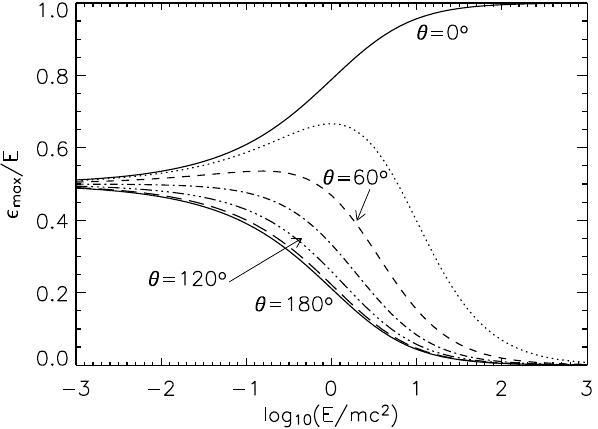

In [12]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

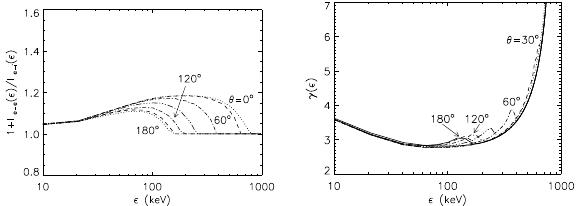

In [13]:
display_base64_image(images[1])

In [ ]:


# Create a Snowflake session
connection = sf.connect(
    user=snowflake_user,
    password= snowflake_password,
    account= snowflake_account,
    # "role": snowflake_role,
    # "warehouse": snowflake_warehouse,
    # "database": snowflake_database,
    # "schema": snowflake_schema,
)

# st.write("Connected to Snowflake successfully!")

# def upload_to_stage(papers, stage_name="research_papers_db.public.fomc"):
#     for paper in papers:
#         pdf_path = paper["pdf_path"]
#         pdf_name = os.path.basename(pdf_path)
#         session.file.put(pdf_path, f"@{stage_name}/{pdf_name}", auto_compress=False)

# upload_to_stage(papers)
# print("PDFs uploaded to Snowflake stage successfully.")


In [ ]:
a=connection.cursor().execute("SELECT * FROM research_papers_db.public.research_papers").fetchall()
print(a)